In [1]:
import sys; sys.path.append('..')
import torch
import time
import config.vgrnn_args as args
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm
from src.vgrnn.model_org import VGRNN
from torch.autograd import Variable
from src.vgrnn.utils import get_roc_scores
from src.vgrnn.data import load_data
from src.vgrnn.process import mask_edges_det, mask_edges_prd, mask_edges_prd_new, transpose_list
plt.rcParams.update({
    'text.usetex': True,
})

In [2]:
# Load Dataset
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

# Load time series adjacent in Sparse and Dense List
adj_time_list, adj_orig_dense_list = load_data('../data/fb')

# Get training edges set and false set uesd to score
train_edges_l = mask_edges_det(adj_time_list)[1]    # (t, #Training Edges, 2)
pos_edges_l, false_edges_l = mask_edges_prd(adj_time_list)  # (t, #Edges, 2)
pos_edges_l_n, false_edges_l_n = mask_edges_prd_new(adj_time_list, adj_orig_dense_list) # (t, #New Edges, 2)
edge_idx_list = transpose_list(train_edges_l)   # (t, 2, #Training Edges)
seq_len = len(train_edges_l)
num_nodes = adj_orig_dense_list[seq_len-1].shape[0]
x_dim = num_nodes
x_in_list = []
for i in range(0, seq_len):
    x_temp = torch.tensor(np.eye(num_nodes).astype(np.float32), device=device)
    x_in_list.append(x_temp.clone().detach())
x_in = Variable(torch.stack(x_in_list))
seq_start = args.seq_start
seq_end = seq_len - 3
tst_after = args.tst_after

In [3]:
# Init Model
model = VGRNN(x_dim, args.h_dim, args.z_dim, args.n_layers, device, bias=True)
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

In [4]:
# Train Model
recorder = {'kld_loss': [], 'nll_loss': [], 'loss': [], 'AUC': [], 'AP': [], 'New AUC': [], 'New AP': []}
for epoch in tqdm(range(args.epochs)):
    t = time.time()
    optimizer.zero_grad()
    kld_loss, nll_loss, _, _, hidden_st, _ = model(
        x_in[seq_start:seq_end], 
        edge_idx_list[seq_start:seq_end], 
        adj_orig_dense_list[seq_start:seq_end])
    loss = kld_loss + nll_loss
    loss.backward()
    optimizer.step()
    nn.utils.clip_grad_norm_(model.parameters(), args.clip)

    print('epoch: {k}, kld_loss = {kld:.3f}, nll_loss = {nll:.3f}, loss = {loss:.4f}'.format(
        k=epoch, kld=kld_loss.mean().item(), 
        nll=nll_loss.mean().item(), 
        loss=loss.mean().item()), 
        end='\r')
    recorder['kld_loss'].append(kld_loss.mean().item())
    recorder['nll_loss'].append(nll_loss.mean().item())
    recorder['loss'].append(loss.mean().item())
    if epoch > tst_after:
        _, _, all_enc_mu, all_prior_mu, _, _ = model(
            x_in[seq_end:], 
            edge_idx_list[seq_end:], 
            adj_orig_dense_list[seq_end:], hidden_st)

        auc_scores_prd, ap_scores_prd = get_roc_scores(
            pos_edges_l[seq_end:], 
            false_edges_l[seq_end:], 
            adj_orig_dense_list[seq_end:], all_enc_mu)

        auc_scores_prd_new, ap_scores_prd_new = get_roc_scores(
            pos_edges_l_n[seq_end:], 
            false_edges_l_n[seq_end:], 
            adj_orig_dense_list[seq_end:], all_enc_mu)

        auc = np.mean(np.array(auc_scores_prd))
        ap = np.mean(np.array(ap_scores_prd))
        nauc = np.mean(np.array(auc_scores_prd_new))
        nap = np.mean(np.array(ap_scores_prd_new))
        recorder['AUC'].append(auc)
        recorder['AP'].append(ap)
        recorder['New AUC'].append(nauc)
        recorder['New AP'].append(nap)

for i in range(100):
    _, _, all_enc_mu, all_prior_mu, _, _ = model(
        x_in[seq_end:], 
        edge_idx_list[seq_end:], 
        adj_orig_dense_list[seq_end:], hidden_st)

    auc_scores_prd, ap_scores_prd = get_roc_scores(
        pos_edges_l[seq_end:], 
        false_edges_l[seq_end:], 
        adj_orig_dense_list[seq_end:], all_prior_mu)

    auc_scores_prd_new, ap_scores_prd_new = get_roc_scores(
        pos_edges_l_n[seq_end:], 
        false_edges_l_n[seq_end:], 
        adj_orig_dense_list[seq_end:], all_prior_mu)

    auc = np.mean(np.array(auc_scores_prd))
    ap = np.mean(np.array(ap_scores_prd))
    nauc = np.mean(np.array(auc_scores_prd_new))
    nap = np.mean(np.array(ap_scores_prd_new))

  0%|          | 0/100 [00:00<?, ?it/s]

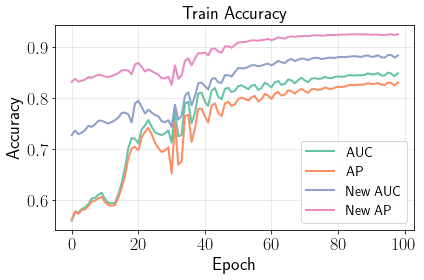

In [5]:
# Plot Loss and Accuracy
fig, axs = plt.subplots(1, figsize=(6, 4))
title_font = {'family': 'Arial Black', 'fontsize': 18, 'fontweight': 'bold'}
label_font = {'family': 'Arial Black', 'fontsize': 18}
legend_font = {'family': 'Palatino Linotype', 'size': 14}
text_font = {'family': 'Palatino Linotype', 'fontsize': 14}

axs.plot(recorder['AUC'], label='AUC', color=cm.Set2(0), lw=2)
axs.plot(recorder['AP'], label='AP', color=cm.Set2(1), lw=2)
axs.plot(recorder['New AUC'], label='New AUC', color=cm.Set2(2), lw=2)
axs.plot(recorder['New AP'], label='New AP', color=cm.Set2(3), lw=2)

axs.set_title('Train Accuracy', fontdict=title_font)
axs.set_xlabel('Epoch', fontdict=label_font)
axs.set_ylabel('Accuracy', fontdict=label_font)
axs.grid(axis='both', color='black', alpha=0.1)
axs.legend(loc='lower right', prop=legend_font)
axs.tick_params(axis='both', which='major', labelsize=18)

labels = axs.get_xticklabels() + axs.get_yticklabels()
[label.set_fontname('serif') for label in labels]
plt.tight_layout()
plt.savefig('../fig/vgrnn_train.jpg')
plt.show()